- Crear Data Loader Dividir la data 80% - 10% - 10%  Utilizando clase DataLoader Pytorch
- Visualizar Imagenes 8 x 8 para comprar simulacion real y simulacion generada
- Normalizar Base de datos entre [-1 , 1]
- Autoencoder con CNN o MLP  - VAE con CNN o MLP
- Validar mediante dimensionalidad
- Entrenar y Generar Graficos Loss Train - Loss Validation - Loss Test
- Visualizar resultados

Se realizaron 200 Simulaciones con parametros constitutivos aleatorios para el modelo Holzapfel 2015, las simulaciones se realizaron en 200 pasos donde se guardaron desde el 50 hasta el final, por lo cual se poseen $151 \cdot 200 = 30200$ "Imagenes" Cada simulacion posee 7701 nodos. 

In [1]:
from IPython import display
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from DataLoader import *
import torchvision
torch.manual_seed(0); # Set for testing purposes, please do not change!



class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 10, kernel_size=3, stride=1, padding=1)
        )


    def forward(self, image):
        enc_pred = self.enc(image)
        return enc_pred

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # define fully connected layer to unflatten the embeddings
        self.decoder = nn.Sequential(
            nn.Conv2d(10, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample((151,51), mode='bilinear', align_corners=False),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Sigmoid para asegurar que las salidas estén en el rango [0, 1]
        )


    def forward(self, x):
        x = self.decoder(x)
        return x



def extract_random_images(data_loader, num_images):

    all_images = []
    for images in data_loader:
        # append the current batch of images and labels to the respective lists
        all_images.append(images)
        # stop the iteration if the total number of images exceeds 1000
        if len(all_images) * data_loader.batch_size > 1000:
            break
    # concatenate all the images and labels tensors along the 0th dimension
    all_images = torch.cat(all_images, dim=0)
    # generate random indices for selecting a subset of images and labels
    random_indices = np.random.choice(len(all_images), num_images, replace=False)
    # use the random indices to extract the corresponding images and labels
    random_images = all_images[random_indices]
    # return the randomly selected images and labels to the calling function
    return random_images


def display_images(images, num_images_per_row, title, filename=None, show=True):
    # calculate the number of rows needed to display all the images
    num_rows = len(images) // num_images_per_row
    # create a grid of images using torchvision's make_grid function
    grid = torchvision.utils.make_grid(
        images.cpu(), nrow=num_images_per_row, padding=2, normalize=True
    )
    # convert the grid to a NumPy array and transpose it to
    # the correct dimensions
    grid_np = grid.numpy().transpose((1, 2, 0))
    # create a new figure with the appropriate size
    plt.figure(figsize=(num_images_per_row * 2, num_rows * 2))
    # show the grid of images
    plt.imshow(grid_np)
    # remove the axis ticks
    plt.axis("off")
    # set the title of the plot
    plt.title(title, fontsize=16)
    # add labels for each image in the grid
    # if show is True, display the plot
    if show:
        plt.show()
    else:
        # otherwise, save the plot to a file and close the figure
        plt.savefig(filename, bbox_inches="tight")
        plt.close()    



def display_random_images(
    data_loader,
    DEVICE,
    encoder=None,
    decoder=None,
    file_recon='Reconstruccion',
    file_real='Real',
    title_recon='RECONSTRUCCION',
    title_real='REAL',
    display_real=True,
    num_images=32,
    num_images_per_row=8,
):
    # extract a random subset of images and labels from the data loader
    random_images= extract_random_images(data_loader, num_images)

    # if an encoder and decoder are provided,
    # use them to generate reconstructions
    if encoder is not None and decoder is not None:
        # set the encoder and decoder to evaluation mode
        #encoder.eval()
        #decoder.eval()
        # move the random images to the appropriate device
        random_images = random_images.to(DEVICE)
        # generate embeddings for the random images using the encoder
        random_embeddings = encoder(random_images)
        # generate reconstructions for the random images using the decoder
        random_reconstructions = decoder(random_embeddings)
        # display the reconstructed images
        display_images(
            random_reconstructions.cpu(),
            num_images_per_row,
            title_recon,
            file_recon,
            show=False,
        )
        # if specified, also display the original images
        if display_real:
            display_images(
                random_images.cpu(),
                num_images_per_row,
                title_real,
                file_real,
                show=False,
            )
    # if no encoder and decoder are provided, simply display the original images
    else:
        display_images(
            random_images, num_images_per_row, title="Real Images"
        )





In [2]:
class MinimalBetaAutoencoder():
    def __init__(self, encoder, decoder, lr = 0.0002, criterion=nn.MSELoss(reduction="sum")):
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)

        self.latent_dim = 10

        self.criterion=criterion

        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = torch.optim.Adam(params, lr=lr, betas=(0.5, 0.999))

        self.log = {}

        for k in ["train_reconstruction_loss", "val_loss"]:
            self.log[k] = []


    def loss(self, x, x_hat):
        batch_size = len(x)
        # reconstruction loss
        recon_loss = self.criterion(x_hat.view(batch_size,-1), x.view(batch_size,-1)).div(batch_size)

        return recon_loss

    
    def decode(self, z):
        """Decodifica lo generado en el espacio latente."""
        return self.decoder(z)

    def encode(self, x):
        """Codifica en el espacio latente"""
        return self.encoder(x)

    def sample(self, n, device="cpu"):
        """Muetreo de n imagenes en espacio latente"""
        z = torch.randn((n,self.latent_dim), device=device)
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch):
        """ "
        Paso de entrenamiento.
        """
        x = batch
        x = x.to(self.device)
        z = self.encode(x) 
        x_hat = self.decode(z).view(x.size())
        recon_loss = self.loss(x, x_hat)

        self.log["train_reconstruction_loss"].append(recon_loss)
        return recon_loss
    
    def validation_step(self, batch, step):
        with torch.no_grad():
            x= batch
            x = x.to(self.device)
            z = self.encode(x) 
            x_hat = self.decode(z).view(x.size())
            loss = self.loss(x, x_hat)

        self.log["val_loss"].append((loss.detach().item(), step))
        return loss


    def forward(self, x):
        """Codifica y decodifica el input"""
        return self.generate(x)
    
    def train(self, dataloader,val_dataloader, n_epochs=20, display_step = 300):
        step_counter = 0
        for epoch in range(n_epochs):
            size = 0
            for batch in dataloader:
                size += len(batch)
                self.optimizer.zero_grad()
                loss = self.training_step(batch)
                loss.backward()
                self.optimizer.step()

                step_counter += 1
                if step_counter%display_step == 0:
                    print(f"Epoch:{epoch} step:{step_counter} loss: {loss.item()}")
                    display.clear_output(wait=False)
                    display_random_images(dataloader,self.device,self.encode,self.decode)
                    print(f"Epoch:{epoch} step:{step_counter} loss: {loss.item()}")

            torch.save(self.encoder.state_dict(), 'conv_encoder.pth')
            torch.save(self.decoder.state_dict(), 'conv_decoder.pth')

            
            for batch in val_dataloader:
                loss = self.validation_step(batch, step_counter)
                break


    def plt_training_curves(self):
        val_loss, steps = list(zip(*self.log["val_loss"]))
        
        plt.plot(range(len(self.log["train_reconstruction_loss"])),
                 torch.stack(self.log["train_reconstruction_loss"]).detach().cpu().numpy(), label="Training Loss")
        
        plt.plot(steps, val_loss, label="Validation Loss")
        plt.grid()
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title(f"VAE Training Beta")
        plt.legend()
        plt.savefig(f"VAE_training_beta.pdf")
        plt.show()
        plt.close()


def plot_2d_latent_vae(model_vae, val_dataset ,batch_size_2 = 128):
    val_dataloader = DataLoader(dataset=val_dataset, 
										batch_size=batch_size_2, 
										shuffle=True)
    latent_mnist = []
    labels = []
    for batch in val_dataloader:
        x, y = batch
        x, y = x.to("cuda"), y.to("cuda")
        latent = model_vae.encode(x)[2].reshape(-1, 2)
        latent_mnist.append(latent)
        labels.append(y)

    latent_mnist = torch.concatenate(latent_mnist).detach().cpu().numpy()
    labels = torch.concatenate(labels).detach().cpu().numpy()
    
    plt.figure(figsize=(6, 6))
    plt.scatter(latent_mnist[:, 0], latent_mnist[:, 1], c=labels,
                alpha=.5, s=3**2, cmap='Set1')
    plt.colorbar()
    plt.xlim((-4,4))
    plt.ylim((-4,4))
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    plt.title(f"Latent Space VAE - MNIST ")
    plt.savefig(f"VAE_Latent_beta.pdf")
    plt.show()

    return latent_mnist, labels



def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [3]:
from arquitectura import *
from DataLoader import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from arquitectura import *
#trial_test
#Imagen_Presurizacion
ruta = '/media/nicolas/DiscoDuro/VAE_DATA/trial_test'
#ruta = '/media/nicolas/DiscoDuro/VAE_DATA/Imagen_Presurizacion' trial_imagen
#ruta = '/media/nicolas/DiscoDuro/VAE_DATA/trial_imagen'



train_dataset = Presurisation_Data_NPZ(ruta,split = 'train')
test_dataset = Presurisation_Data_NPZ(ruta,split = 'test')
val_dataset = Presurisation_Data_NPZ(ruta,split = 'val')



# Para almacenar los latentes de las VAE entrenadas para diferentes betas. 
results_plot_2d = []

device = "cuda" if torch.cuda.is_available() else "cpu"
gen = Decoder().to(device)
enc = Encoder().to(device) 
gen = gen.apply(weights_init)
enc = enc.apply(weights_init)

dataloader = DataLoader(dataset=train_dataset, 
										batch_size=12, 
										shuffle=True)
#Validation Dataloader
val_dataloader = DataLoader(dataset=val_dataset, 
										batch_size=12, 
										shuffle=True)

# Training
vae = MinimalBetaAutoencoder(encoder=enc,decoder=gen)


In [4]:
vae.train(dataloader,val_dataloader, n_epochs=1)


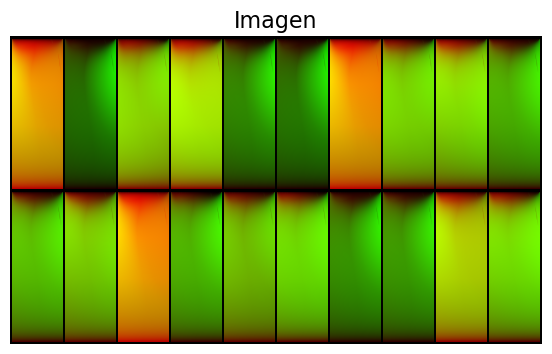

In [5]:
a = extract_random_images(dataloader, 20)
display_images(a, 10, 'Imagen')

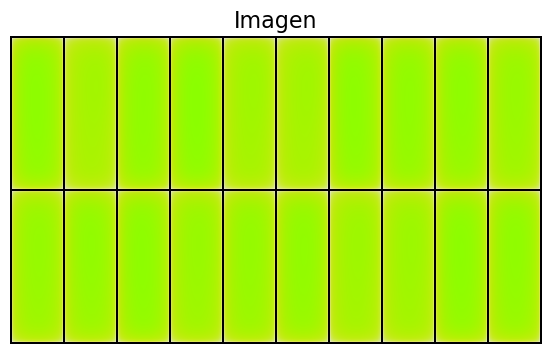

In [6]:

encrip = enc(a.detach().to(device))
des = gen(encrip)
des.shape
display_images(des, 10, 'Imagen')